建物データと浸水面標高ラスターデータから建物の被災データを生成。（必要手続き：Driveの接続）

In [ ]:
# @title Googleドライブの準備
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# @title 設定するパラメータ

# ケース名：解析を通して使います。
casename = "kurume-r2-rev2"

# 浸水範囲を求める際に設定した最大水深
maxdepth = 4.27


In [ ]:
# buildings_json_path = "/content/drive/MyDrive/PLATEAU-FloodSAR/kurume-r2-dev/buildings_parsed.json"

In [ ]:
# @title 詳細設定用パラメータ（基本的には操作不要）

enable_savefig = False # 図をGoogleドライブに保存する？

zoomlevel = 15 # DEM zoom level to fetch

# デバッグ用出力
global globalflag_debug

# 保存先
path_home = "/content/drive/MyDrive/plateau-2023-uc01-satellite-analytics/PLATEAU-FloodSAR/"
path_cgml = path_home + "/CityGML/"
path_dem = path_home + "/DEM/"
path_case = path_home + casename + "/"
path_upload = path_case + "ForUpload/"
file_flbbox = path_case + "floodprb_bbox.npy"
json_boundary = path_case +"boundary.json"
file_bbox = path_case + "boundbox.npy"

file_flooddem = path_case + "flood_dem_{:04d}.npz"
file_flooddepth = path_case + "flood_depth_{:04d}.npz"
file_building_csv = path_case + "flood_buildings.csv"

zipfile_flooddem_tile = path_upload + "tile_flood_dem.zip"
zipfile_floodgeoid_tile = path_upload + "tile_flood_geoid.zip"

In [ ]:
#@title ライブラリインポート
!pip install plateauutils
import matplotlib.pyplot as plt
import numpy as np
from shapely import box
from scipy import interpolate
from progressbar import progressbar
import os
import sys
import shutil
import plateauutils
sys.path.append(path_home)
import plateau_floodsar_lib as pfsl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.7/99.7 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.6/151.6 kB 16.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 42.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 82.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 54.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 73.0 MB/s eta 0:00:00
  Created wheel for earcut: filename=earcut-1.1.5-py3-none-any.whl size=8734 sha256=689b65c5fa90db16311c8b0f9f6b8386db667b97238f9f90fcc3891b7e9b54f5
  Stored in directory: /root/.cache/pip/wheels/1d/44/c4/ae3b04eee88104a19850c1cbc658fa398560c35ba5956faa79
  Creat

In [ ]:
if not os.path.exists(path_upload):
  os.mkdir(path_upload)

In [ ]:
# @title 領域の読み込み
boundbox = np.load(file_flbbox)
print(boundbox)

[130.40008279  33.22512157 130.6999996   33.36663976]


In [ ]:
# @title ジオイド高マップ取得
bbox = box(*boundbox)
print(bbox)
ggh = pfsl.GiajGeoidHandler(path_home)
ggh.load_dem_tiles(bbox)

POLYGON ((130.69999959514536 33.225121566010124, 130.69999959514536 33.366639756095395, 130.40008279106954 33.366639756095395, 130.40008279106954 33.225121566010124, 130.69999959514536 33.225121566010124))


100% (1 of 1) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00


In [ ]:
tile = ggh.produce_tile_stiched()
geo_data = tile["geoid"]
geo_lons = tile["lons"]
geo_lats = tile["lats"]
idx_l = np.where(boundbox[0] <= geo_lons)[0][0]-1
idx_h = np.where(boundbox[2] < geo_lons)[0][0]+1
#print(idx_l, idx_h)
idy_l = np.where(boundbox[3] >= geo_lats)[0][0]-1
idy_h = np.where(boundbox[1] > geo_lats)[0][0]+1
#print(idy_l, idy_h)
geo_data = geo_data[idy_l:idy_h+1,idx_l:idx_h+1]
geo_lons = geo_lons[idx_l:idx_h+1]
geo_lats = geo_lats[idy_l:idy_h+1]

[130.40008279  33.22512157 130.6999996   33.36663976]


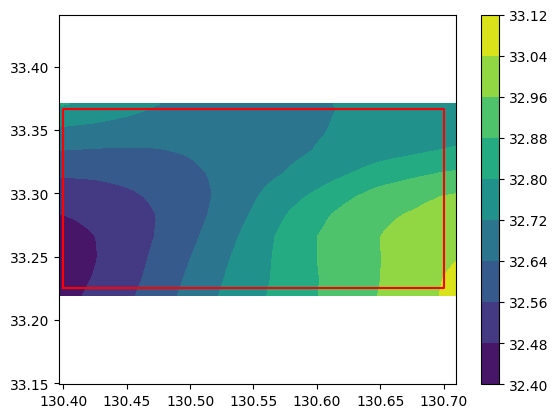

In [ ]:
#@title ジオイド高の確認
print(boundbox)
boxline_x = [boundbox[0],boundbox[2],boundbox[2],boundbox[0],boundbox[0]]
boxline_y = [boundbox[1],boundbox[1],boundbox[3],boundbox[3],boundbox[1]]
ax =plt.subplot(1,1,1)
#img = ax.contourf(geo_data)#,levels=np.arange(1,cnt+10,10))
img = ax.contourf(geo_lons, geo_lats, geo_data)#,levels=np.arange(1,cnt+10,10))
plt.plot(boxline_x,boxline_y, "r-")
ax.axis("equal")
plt.colorbar(img)

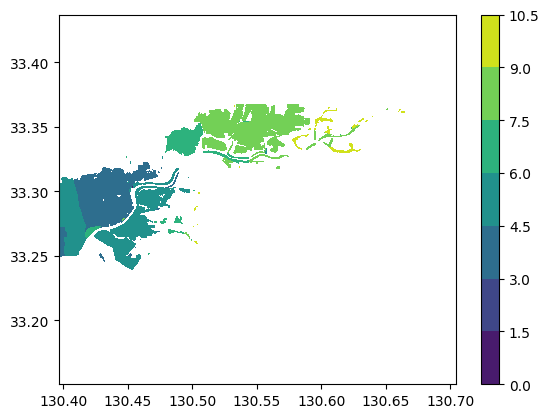

In [ ]:
#@title 浸水DEMラスターの読み込みと確認
dem_map = np.load(file_flooddem.format(int(maxdepth*100)))
lons = dem_map["lons"]
lats = dem_map["lats"]
demmap = dem_map["floodmap_dem"]

ax =plt.subplot(1,1,1)
img = ax.contourf(lons,lats, demmap)#,levels=np.arange(0,maxdepth+0.1,0.25))
ax.axis("equal")
plt.colorbar(img)

In [ ]:
#@title 楕円体高への変換
print(len(geo_lats), len(geo_lons), np.shape(geo_data))
geoInterp = interpolate.RectBivariateSpline(geo_lats[::-1], geo_lons, geo_data[::-1,::])
tmp = geoInterp(lats[::-1],lons)[::-1,:]
print(np.shape(tmp), np.max(tmp), np.min(tmp))
geomap = demmap + tmp
#print("\nUp to ", len(lons))
#for ii, lon in progressbar(enumerate(lons)):
#  for jj,lat in enumerate(lats):
#    demmap[jj,ii] += ggh.calc_dem_interp(lon, lat)

34 58 (34, 58)
(4096, 7168) 33.05213467648333 32.44529952016204


(7168, 4096, (4096, 7168))


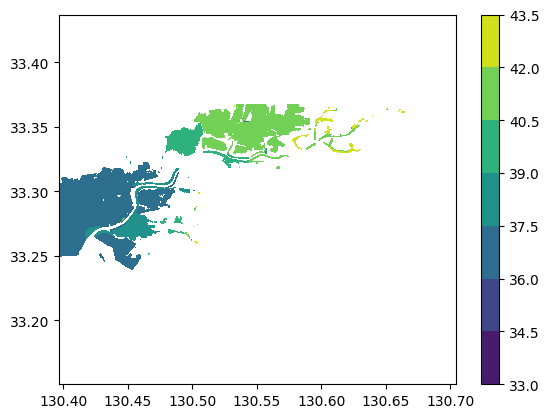

In [ ]:
print((len(lons), len(lats), np.shape(geomap)))
ax =plt.subplot(1,1,1)
img = ax.contourf(lons,lats, geomap)#,levels=np.arange(0,maxdepth+0.1,0.25))
ax.axis("equal")
plt.colorbar(img)

In [ ]:
#print(len(lats)/256.0, len(lons)/256.0)
import zipfile
import os

def save_tile_npz(lats,lons,map,zoom=15, dst_dir ="temp/"):
  dir_zoom = dst_dir + f"{zoom}/"
  if not os.path.exists(dir_zoom):
    os.makedirs(dir_zoom)
  res_lons = np.array([])
  res_lats = np.array([])
  res_maps = np.array([])
  for jj, tmp_lat in enumerate(lats[::256]):
    idj = jj*256
    sublats = lats[idj:idj+256]
    for ii, tmp_lon in enumerate(lons[::256]):
      idi = ii*256
      sublons = lons[idi:idi+256]
      xx,yy  = pfsl.calc_xyz_from_lonlat(tmp_lon, tmp_lat, zoom)
      #print(ii,jj, xx, yy)
      submap = map[idj:idj+256,idi:idi+256]
      grd_lons, grd_lats  = np.meshgrid(sublons,sublats)
      flt_lons = grd_lons.ravel()
      flt_lats = grd_lats.ravel()
      flt_map = submap.ravel()
      #selected = [[lon,lat,dem] for lon, lat, dem in zip(flt_lons, flt_lats,flt_map) if not np.isnan(dem)]
      #print(flt_lons[0:5])
      #print(flt_lats[0:5])
      #print(flt_map[0:5])
      #print(ii, jj, f"{subzoom}-{xx}-{yy}", f"{subzoom}-{chk_tile[0]}-{chk_tile[1]}")
      if not os.path.exists(f"{dir_zoom}{xx}"):
        os.mkdir(f"{dir_zoom}{xx}")
      np.savez(f"{dir_zoom}{xx}/{yy}.npz", lons=flt_lons, lats=flt_lats, map=flt_map)
      res_lons = np.append(res_lons, flt_lons)
      res_lats = np.append(res_lats, flt_lats)
      res_maps = np.append(res_maps, flt_map)
  return res_lons, res_lats, res_maps


In [ ]:
#save_tile_npz(lats,lons,demmap,dst_dir="flooddem/")
test_lons, test_lats, test_maps = save_tile_npz(lats,lons,geomap,dst_dir="ellipsoid/")

In [ ]:
plt_lons = test_lons[np.where(~np.isnan(test_maps))]
plt_lats = test_lats[np.where(~np.isnan(test_maps))]

(130.38335824012756,
 130.67750430107117,
 33.233095108745474,
 33.373567742169115)

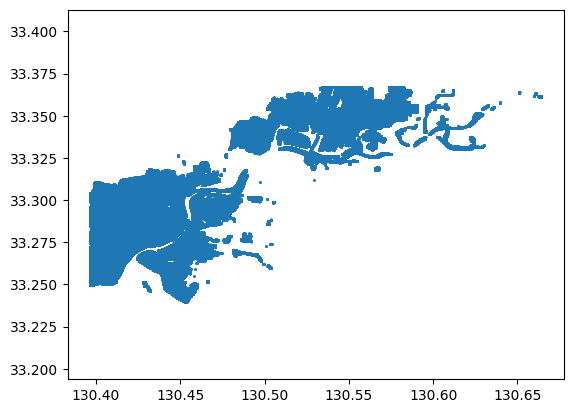

In [ ]:
plt.scatter(plt_lons,plt_lats, s=0.5)
plt.axis("equal")

In [ ]:
from plateauutils.flood_converter.flood_to_3dtiles import FloodTo3dtiles

/usr/local/lib/python3.10/dist-packages/py3dtiles/tilers/node/distance.py:22: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(cache=True, nogil=True)


In [ ]:
tilecnv = FloodTo3dtiles()

In [ ]:
#tilecnv.convert("flooddem/", path_upload+"flood3dtile_dem/")

In [ ]:
#shutil.make_archive(path_upload+'flood3dtile_dem_zip', 'zip',  path_upload+"flood3dtile_dem/")

In [ ]:
# 出力先のディレクトリが存在していたら消すこと

In [ ]:
path_flood3Dnpz = path_upload+"flood3dtile_ellipsoid-flip/"

In [ ]:
tilecnv.convert("ellipsoid/", path_flood3Dnpz)

 100.0 % in 354 sec [est. time left: 0 sec]      

In [ ]:
shutil.make_archive(path_upload+'flood3dtile_ellipsoid-flip_zip', 'zip', path_flood3Dnpz)

'/content/drive/MyDrive/PLATEAU-FloodSAR/kurume-r2-rev2-check/ForUpload/flood3dtile_ellipsoid-flip_zip.zip'

In [ ]:
from plateauutils.flood_converter.flood_to_png import FloodToPng
p = FloodToPng("ellipsoid/")
p.parse(path_upload+'ellipsoid_png')

In [ ]:
!python --version

Python 3.10.12
